In [1]:
import numpy as np
import cooler
import pandas as pd 
import multiprocessing
from scipy.signal import find_peaks, peak_prominences
import scipy
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

import scipy.sparse
import os
from scipy.stats import zscore

In [2]:
# def getmat(cell_name, allele):
#     file_path = f"/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/imputation/data/{cell_name}_chrX{allele}.npz"
#     mat = np.load(file_path, allow_pickle=True)["data"][()]
#     mat = mat.todense()
#     mat = mat*1e6
#     return mat

In [3]:
def get_clr(path, resolution = '1000000'):
    clr = cooler.Cooler(path+'::/resolutions/'+resolution)
    return(clr)

def getBins(path,resolution = '1000000'):
    clr = get_clr(path,resolution = resolution)
    binsInfo = {}
    chroms = clr.chroms()["name"][:]
    for chrom in chroms:
        idxarray = np.where(clr.bins()["chrom"][:] == chrom)
        chromstart = idxarray[0][0]
        chromend = idxarray[0][-1]
        binsInfo[chrom] = [chromstart,chromend]
        #print chrom, (chromend - chromstart + 1)
    return clr,binsInfo

In [4]:
tad = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/new_version/my_tad_filtered_mod_tadE_new.csv", index_col = 0)

In [5]:
cellname = "d0A1"
chro = "chrX(pat)"
clr = cooler.Cooler(f"/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/HiC_analysis/visual/scHiC_analysis/dip_mcools/{cellname}.balanced.mcool::/resolutions/20000")
clr.matrix(balance=False).fetch(chro)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [21]:
def getmat_raw(cell_name, chro):
    clr = cooler.Cooler(f"/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/HiC_analysis/visual/bulkHiC_analysis/processed/mcools/{cell_name}.balanced.mcool::/resolutions/20000")
    mat = clr.matrix(balance=False).fetch(chro)
    return mat

In [7]:
metadata = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/s1014_metadata_X_noM_noXistneg.csv")

In [8]:
cellnames = metadata['cellname'].values

In [10]:
from multiprocessing import Pool, cpu_count
import warnings
import tqdm

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

def calculate_tad_score(cellname):
    try:
        data = getmat_raw(cellname, chro)
        tad_score = []

        for i in range(tad.shape[0]):
            start_bin = tad.iloc[i]["start"]
            start_bin = int(start_bin)
            end_bin = tad.iloc[i]["end"]
            end_bin = int(end_bin)

            temp = data[start_bin:end_bin, start_bin:end_bin].copy()
            diagnal = np.diagonal(temp).copy()

            np.fill_diagonal(temp, 0)

            intra_contacts = np.nansum(temp) / 2 + np.nansum(diagnal)
            all_contacts = np.nansum(data[start_bin:end_bin, :]) - np.nansum(temp) + intra_contacts
            tad_score.append(intra_contacts / all_contacts)

        return cellname, tad_score

    except Exception as e:
        return cellname, None, str(e)

chro = "chrX(pat)"

with Pool(processes=cpu_count()) as pool:
    results = list(tqdm.tqdm(pool.imap(calculate_tad_score, cellnames), total=len(cellnames)))

tad_dict = {}
errors = {}
for result in results:
    if len(result) == 3:
        cellname, _, error = result
        errors[cellname] = error
    else:
        cellname, tad_score = result
        tad_dict[cellname] = tad_score

if errors:
    for cellname, error in errors.items():
        print(f"Error processing {cellname}: {error}")

tad_features = pd.DataFrame(tad_dict)

tad_features = tad_features.copy()

  0%|▌                                                                                                                                                                                                                                                                           | 2/904 [00:00<02:44,  5.47it/s]/tmp/ipykernel_41138/4250037829.py:26: RuntimeWarning: invalid value encountered in double_scalars
  tad_score.append(intra_contacts / all_contacts)
  7%|██████████████████▊                                                                                                                                                                                                                                                       | 64/904 [00:00<00:07, 109.52it/s]/tmp/ipykernel_41138/4250037829.py:26: RuntimeWarning: invalid value encountered in double_scalars
  tad_score.append(intra_contacts / all_contacts)
 13%|█████████████████████████████████▋                                                     

In [11]:
tad_features

,d0A1,d0A10,d0A11,d0A12,d0A13,d0A14,d0A15,d0A16,d0A17,d0A18,...,d15D84,d15D86,d15D87,d15D88,d15D89,d15D90,d15D92,d15D94,d15D96,d15D97
0,0.222222,0.000000,0.166667,0.333333,0.285714,0.833333,0.200000,0.500000,0.166667,0.260870,...,0.111111,0.500000,0.333333,0.266667,0.187500,0.375000,0.363636,0.000000,0.285714,0.300000
1,0.187500,0.470588,0.416667,0.120000,0.590909,0.720000,0.368421,0.600000,0.269231,0.130435,...,0.250000,0.583333,0.333333,0.419355,0.296296,0.100000,0.214286,0.312500,0.176471,0.066667
2,0.307692,0.142857,0.333333,0.380952,0.166667,0.600000,0.310345,0.562500,0.406780,0.294118,...,0.210526,0.285714,0.260870,0.363636,0.121212,0.444444,0.208333,0.240000,0.189189,0.529412
3,0.333333,0.523810,0.500000,0.538462,0.390476,0.531250,0.409639,0.289474,0.400000,0.270270,...,0.291667,0.454545,0.442623,0.413333,0.436364,0.260870,0.345455,0.295455,0.224138,0.674419
4,0.500000,0.705882,0.166667,0.473684,0.590909,0.521739,0.255319,0.142857,0.620690,0.291667,...,0.500000,0.517241,0.200000,0.692308,0.435897,0.342105,0.265306,0.588235,0.304348,0.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.321918,0.159091,0.200000,0.300752,0.198718,0.257143,0.398693,0.506329,0.666667,0.339286,...,0.583333,0.507692,0.358974,0.579545,0.386207,0.445946,0.616438,0.355556,0.492754,0.457364
108,0.156250,0.250000,0.380952,0.384615,0.280374,0.148649,0.445545,0.406780,0.507042,0.418605,...,0.448276,0.594595,0.326087,0.349206,0.391304,0.400000,0.000000,0.132075,0.171429,0.302326
109,0.142857,0.000000,0.200000,0.157895,0.270833,0.125000,0.296296,0.125000,0.192308,0.800000,...,0.272727,0.363636,0.277778,0.269231,0.235294,0.363636,0.000000,0.285714,0.190476,0.055556
110,0.166667,0.000000,0.500000,0.583333,0.272727,0.177778,0.281250,0.187500,0.333333,0.375000,...,0.111111,0.120000,0.434783,0.305556,0.185185,0.285714,0.187500,0.200000,0.206897,0.200000


In [12]:
tad_features.to_csv("raw_intra_prop_B6_112.csv")

In [13]:
scores_pat_mean = pd.DataFrame(tad_features.mean())
scores_pat_mean.columns = ["pat"]
scores_pat_mean['cellname'] = cellnames

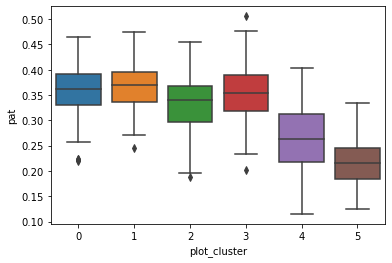

In [14]:
import seaborn as sns
ax = sns.boxplot(data = pd.merge(scores_pat_mean,metadata[['plot_cluster','cellname']]), x = "plot_cluster", y = "pat")

In [16]:
from multiprocessing import Pool, cpu_count
import warnings
import tqdm

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

def calculate_tad_score(cellname):
    try:
        data = getmat_raw(cellname, chro)
        tad_score = []

        for i in range(tad.shape[0]):
            start_bin = tad.iloc[i]["start"]
            start_bin = int(start_bin)
            end_bin = tad.iloc[i]["end"]
            end_bin = int(end_bin)

            temp = data[start_bin:end_bin, start_bin:end_bin].copy()
            diagnal = np.diagonal(temp).copy()

            np.fill_diagonal(temp, 0)

            intra_contacts = np.nansum(temp) / 2 + np.nansum(diagnal)
            all_contacts = np.nansum(data[start_bin:end_bin, :]) - np.nansum(temp) + intra_contacts
            tad_score.append(intra_contacts / all_contacts)

        return cellname, tad_score

    except Exception as e:
        return cellname, None, str(e)

chro = "chrX(mat)"

with Pool(processes=cpu_count()) as pool:
    results = list(tqdm.tqdm(pool.imap(calculate_tad_score, cellnames), total=len(cellnames)))

tad_dict = {}
errors = {}
for result in results:
    if len(result) == 3:
        cellname, _, error = result
        errors[cellname] = error
    else:
        cellname, tad_score = result
        tad_dict[cellname] = tad_score

if errors:
    for cellname, error in errors.items():
        print(f"Error processing {cellname}: {error}")

tad_features = pd.DataFrame(tad_dict)

tad_features = tad_features.copy()

  0%|                                                                                                                                                                                                                                                                                    | 0/904 [00:00<?, ?it/s]/tmp/ipykernel_41138/4005947981.py:26: RuntimeWarning: invalid value encountered in double_scalars
  tad_score.append(intra_contacts / all_contacts)
/tmp/ipykernel_41138/4005947981.py:26: RuntimeWarning: invalid value encountered in double_scalars
  tad_score.append(intra_contacts / all_contacts)
  0%|▎                                                                                                                                                                                                                                                                           | 1/904 [00:00<07:03,  2.13it/s]/tmp/ipykernel_41138/4005947981.py:26: RuntimeWarning: invalid value encountered in double_s

In [17]:
scores_mat_mean = pd.DataFrame(tad_features.mean())
scores_mat_mean.columns = ["mat"]
scores_mat_mean['cellname'] = cellnames

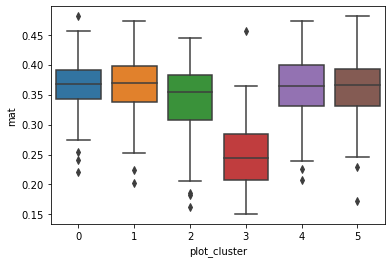

In [18]:
import seaborn as sns
ax = sns.boxplot(data = pd.merge(scores_mat_mean,metadata[['plot_cluster','cellname']]), x = "plot_cluster", y = "mat")

In [20]:
tad_features.to_csv("raw_intra_prop_Cast_112.csv")